# Asymptotic Stability of a Flying Wing in Cruise Trimmed Conditions

A Horten flying wing is analysed. The nonlinear trim condition is found and the system is linearised. The eigenvalues of the linearised system are then used to evaluate the stability at the cruise trimmed flight conditions.

In [1]:
# required packages
import sharpy.utils.algebra as algebra
import sharpy.sharpy_main
from cases.hangar.richards_wing import Baseline
import numpy as np
import configobj
import matplotlib.pyplot as plt

## Flight Conditions

Initial flight conditions. The values for angle of attack ``alpha``, control surface deflection ``cs_deflection`` and ``thrust`` are only initial values. The values required for trim will be calculated by the ``StaticTrim`` routine

In [2]:
u_inf = 28
alpha_deg = 4.5135
cs_deflection = 0.1814
thrust = 5.5129

## Discretisation

In [3]:
M = 4  # chordwise panels
N = 11  # spanwise panels
Msf = 5  # wake length in chord numbers

## Create Horten Wing

In [4]:
ws = Baseline(M=M,
              N=N,
              Mstarfactor=Msf,
              u_inf=u_inf,
              rho=1.02,
              alpha_deg=alpha_deg,
              roll_deg=0,
              cs_deflection_deg=cs_deflection,
              thrust=thrust,
              physical_time=20,
              case_name='horten',
              case_name_format=4,
              case_remarks='M%gN%gMsf%g' % (M, N, Msf))

ws.set_properties()
ws.initialise()
ws.clean_test_files()

ws.update_mass_stiffness(sigma=1., sigma_mass=2.5)
ws.update_fem_prop()
ws.generate_fem_file()
ws.update_aero_properties()
ws.generate_aero_file()

0
Section Mass: 11.88 
Linear Mass: 11.88
Section Ixx: 1.8777
Section Iyy: 1.0137
Section Izz: 2.5496
Linear Ixx: 1.88
1
Section Mass: 10.99 
Linear Mass: 10.99
Section Ixx: 1.4694
Section Iyy: 0.9345
Section Izz: 2.1501
Linear Ixx: 1.74
2
Section Mass: 10.10 
Linear Mass: 10.10
Section Ixx: 1.1257
Section Iyy: 0.8561
Section Izz: 1.7993
Linear Ixx: 1.60
3
Section Mass: 9.21 
Linear Mass: 9.21
Section Ixx: 0.8410
Section Iyy: 0.7783
Section Izz: 1.4933
Linear Ixx: 1.46
4
Section Mass: 8.32 
Linear Mass: 8.32
Section Ixx: 0.6096
Section Iyy: 0.7011
Section Izz: 1.2280
Linear Ixx: 1.31
5
Section Mass: 7.43 
Linear Mass: 7.43
Section Ixx: 0.4260
Section Iyy: 0.6246
Section Izz: 0.9996
Linear Ixx: 1.17
6
Section Mass: 6.54 
Linear Mass: 6.54
Section Ixx: 0.2845
Section Iyy: 0.5485
Section Izz: 0.8040
Linear Ixx: 1.03
7
Section Mass: 5.64 
Linear Mass: 5.64
Section Ixx: 0.1796
Section Iyy: 0.4728
Section Izz: 0.6374
Linear Ixx: 0.89
8
Section Mass: 4.75 
Linear Mass: 4.75
Section Ixx: 0.105

## Simulation Information

The ``flow`` setting tells SHARPy which solvers to run and in which order. You may be stranged by the presence of the ``DynamicCoupled`` solver but it is necessary to give an initial speed to the structure. This will allow proper linearisation of the structural and rigid body equations.

In [5]:
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticTrim',
        'BeamPlot',
        'AerogridPlot',
        'AeroForcesCalculator',
        'DynamicCoupled',
        'Modal',
        'LinearAssembler',
        'AsymptoticStability',
        'StabilityDerivatives',
        ]

### SHARPy Settings

In [6]:
settings = dict()
settings['SHARPy'] = {'case': ws.case_name,
                      'route': ws.case_route,
                      'flow': flow,
                      'write_screen': 'on',
                      'write_log': 'on',
                      'log_folder': './output/' + ws.case_name + '/',
                      'log_file': ws.case_name + '.log'}



### Loaders

In [7]:
settings['BeamLoader'] = {'unsteady': 'off',
                          'orientation': algebra.euler2quat(np.array([ws.roll,
                                                                      ws.alpha,
                                                                      ws.beta]))}
settings['AerogridLoader'] = {'unsteady': 'off',
                              'aligned_grid': 'on',
                              'mstar': int(ws.M * ws.Mstarfactor),
                              'freestream_dir': ['1', '0', '0'],
                              'control_surface_deflection': ['']}

### StaticCoupled Solver

In [8]:
settings['StaticCoupled'] = {'print_info': 'on',
                             'structural_solver': 'NonLinearStatic',
                             'structural_solver_settings': {'print_info': 'off',
                                                            'max_iterations': 200,
                                                            'num_load_steps': 1,
                                                            'delta_curved': 1e-5,
                                                            'min_delta': ws.tolerance,
                                                            'gravity_on': 'on',
                                                            'gravity': 9.81},
                             'aero_solver': 'StaticUvlm',
                             'aero_solver_settings': {'print_info': 'on',
                                                      'horseshoe': ws.horseshoe,
                                                      'num_cores': 4,
                                                      'n_rollup': int(0),
                                                      'rollup_dt': ws.dt,
                                                      'rollup_aic_refresh': 1,
                                                      'rollup_tolerance': 1e-4,
                                                      'velocity_field_generator': 'SteadyVelocityField',
                                                      'velocity_field_input': {'u_inf': ws.u_inf,
                                                                               'u_inf_direction': [1., 0, 0]},
                                                      'rho': ws.rho},
                             'max_iter': 200,
                             'n_load_steps': 1,
                             'tolerance': ws.tolerance,
                             'relaxation_factor': 0.2}

### Trim solver

In [9]:
settings['StaticTrim'] = {'solver': 'StaticCoupled',
                          'solver_settings': settings['StaticCoupled'],
                          'thrust_nodes': ws.thrust_nodes,
                          'initial_alpha': ws.alpha,
                          'initial_deflection': ws.cs_deflection,
                          'initial_thrust': ws.thrust,
                          'max_iter': 200,
                          'fz_tolerance': 1e-2,
                          'fx_tolerance': 1e-2,
                          'm_tolerance': 1e-2}

### Nonlinear Equilibrium Post-process

In [10]:
settings['AerogridPlot'] = {'folder': './output/',
                            'include_rbm': 'off',
                            'include_applied_forces': 'on',
                            'minus_m_star': 0,
                            'u_inf': ws.u_inf
                            }
settings['AeroForcesCalculator'] = {'folder': './output/',
                                    'write_text_file': 'off',
                                    'text_file_name': ws.case_name + '_aeroforces.csv',
                                    'screen_output': 'on',
                                    'unsteady': 'off',
                                    'coefficients': True,
                                    'q_ref': 0.5 * ws.rho * ws.u_inf ** 2,
                                    'S_ref': 12.809,
                                    }

settings['BeamPlot'] = {'folder': './output/',
                        'include_rbm': 'on',
                        'include_applied_forces': 'on',
                        'include_FoR': 'on'}

### DynamicCoupled Solver

As mentioned before, a single time step of ``DynamicCoupled`` is required to give the structure the velocity required for the linearisation of the rigid body equations to be correct. Hence `n_time_steps = 1`

In [11]:
struct_solver_settings = {'print_info': 'off',
                          'initial_velocity_direction': [-1., 0., 0.],
                          'max_iterations': 950,
                          'delta_curved': 1e-6,
                          'min_delta': ws.tolerance,
                          'newmark_damp': 5e-3,
                          'gravity_on': True,
                          'gravity': 9.81,
                          'num_steps': ws.n_tstep,
                          'dt': ws.dt,
                          'initial_velocity': ws.u_inf * 1}

step_uvlm_settings = {'print_info': 'on',
                      'horseshoe': ws.horseshoe,
                      'num_cores': 4,
                      'n_rollup': 1,
                      'convection_scheme': ws.wake_type,
                      'rollup_dt': ws.dt,
                      'rollup_aic_refresh': 1,
                      'rollup_tolerance': 1e-4,
                      'velocity_field_generator': 'SteadyVelocityField',
                      'velocity_field_input': {'u_inf': ws.u_inf * 0,
                                               'u_inf_direction': [1., 0., 0.]},
                      'rho': ws.rho,
                      'n_time_steps': ws.n_tstep,
                      'dt': ws.dt,
                      'gamma_dot_filtering': 3}

settings['DynamicCoupled'] = {'print_info': 'on',
                              'structural_solver': 'NonLinearDynamicCoupledStep',
                              'structural_solver_settings': struct_solver_settings,
                              'aero_solver': 'StepUvlm',
                              'aero_solver_settings': step_uvlm_settings,
                              'fsi_substeps': 200,
                              'fsi_tolerance': ws.fsi_tolerance,
                              'relaxation_factor': ws.relaxation_factor,
                              'minimum_steps': 1,
                              'relaxation_steps': 150,
                              'final_relaxation_factor': 0.5,
                              'n_time_steps': 1,
                              'dt': ws.dt,
                              'include_unsteady_force_contribution': 'off',
                                                          }

### Modal Solver Settings

In [12]:
settings['Modal'] = {'print_info': True,
                     'use_undamped_modes': True,
                     'NumLambda': 30,
                     'rigid_body_modes': True,
                     'write_modes_vtk': 'on',
                     'print_matrices': 'on',
                     'write_data': 'on',
                     'continuous_eigenvalues': 'off',
                     'dt': ws.dt,
                     'plot_eigenvalues': False,
                     'rigid_modes_cg': False}

### Linear Assembler Settings

Note that for the assembly of the linear system, we replace the parametrisation of the orientation with Euler angles instead of quaternions.

In [13]:
settings['LinearAssembler'] = {'linear_system': 'LinearAeroelastic',
                               'linear_system_settings': {
                                   'beam_settings': {'modal_projection': 'off',
                                                     'inout_coords': 'modes',
                                                     'discrete_time': True,
                                                     'newmark_damp': 0.5e-2,
                                                     'discr_method': 'newmark',
                                                     'dt': ws.dt,
                                                     'proj_modes': 'undamped',
                                                     'num_modes': 9,
                                                     'print_info': 'on',
                                                     'gravity': 'on',
                                                     'remove_dofs': []},
                                   'aero_settings': {'dt': ws.dt,
                                                     'integr_order': 2,
                                                     'density': ws.rho,
                                                     'remove_predictor': 'off',
                                                     'use_sparse': 'off',
                                                     'rigid_body_motion': 'on',
                                                     'remove_inputs': ['u_gust']},
                                   'rigid_body_motion': True,
                                   'track_body': 'on',
                                   'use_euler': 'on',
                                   'linearisation_tstep': -1
                                }}

### Asymptotic Stability Post-processor

In [14]:
settings['AsymptoticStability'] = {
                                    'print_info': 'on',
                                    'frequency_cutoff': 0,
                                    'export_eigenvalues': 'on',
                                    'num_evals': 1000,
                                    'folder': './output/'}

### Stability Derivatives Post-processor

In [15]:
settings['StabilityDerivatives'] = {'u_inf': ws.u_inf,
                                    'S_ref': 12.809,
                                    'b_ref': ws.span,
                                    'c_ref': 0.719}

### Write solver file

In [16]:
config = configobj.ConfigObj()
np.set_printoptions(precision=16)
file_name = ws.case_route + '/' + ws.case_name + '.sharpy'
config.filename = file_name
for k, v in settings.items():
    config[k] = v
config.write()

## Run Simulation

In [17]:
data = sharpy.sharpy_main.main(['', ws.case_route + '/' + ws.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved. 
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/ng213/code/sharpy/docs/source/content/example_notebooks
SHARPy being run is in /home/ng213/code/sharpy
The branch being run is dev_examples
The version and com

| 10  |  0  | -12.29756  | -9.2200  |  0.0000  | 293.0287 | -0.0000  |-766.9835 |  0.0000  |
|    0     |  4.5135  |  3.0462  |  5.5129  | -9.2200  |  0.0000  | 293.0287 | -0.0000  |-766.9835 |  0.0000  |
|  0  |  0  |  0.00000   | -4.1051  | -0.0000  |  0.0604  | -0.0000  |  1.0812  | -0.0000  |
|  1  |  0  |  -7.62660  | -4.1120  | -0.0000  |  0.1274  | -0.0000  |  0.0023  | -0.0000  |
|  2  |  0  |  -8.34116  | -4.0942  | -0.0000  |  0.0393  |  0.0000  | -0.0796  | -0.0000  |
|  3  |  0  |  -9.29268  | -4.0871  |  0.0000  |  0.0007  | -0.0000  | -0.0093  |  0.0000  |
|  4  |  0  | -10.67446  | -4.0876  |  0.0000  |  0.0028  |  0.0000  | -0.0123  |  0.0000  |
|  5  |  0  | -10.86979  | -4.0878  |  0.0000  |  0.0039  | -0.0000  | -0.0142  |  0.0000  |
|  6  |  0  | -11.64229  | -4.0878  |  0.0000  |  0.0037  | -0.0000  | -0.0138  |  0.0000  |
|  7  |  0  | -12.86703  | -4.0878  |  0.0000  |  0.0037  | -0.0000  | -0.0138  |  0.0000  |
|    0     |  4.5135  |  0.1814  |  7.5129  | -4.08

/home/ng213/code/sharpy/sharpy/aero/utils/uvlmlib.py:230: RuntimeWarning: invalid value encountered in true_divide
  flightconditions.uinf_direction = np.ctypeslib.as_ctypes(ts_info.u_ext[0][:, 0, 0]/flightconditions.uinf)


|   1   | 0.0089 |  3   |   0.652648   |   0.921936   |  -10.549271  |-2.791317e+01 |-2.203427e+00 |
...Finished
Generating an instance of Modal
Variable folder has no assigned value in the settings file.
    will default to the value: ./output
Variable keep_linear_matrices has no assigned value in the settings file.
    will default to the value: c_bool(True)
Variable write_dat has no assigned value in the settings file.
    will default to the value: c_bool(True)
Variable delta_curved has no assigned value in the settings file.
    will default to the value: c_double(0.01)
Variable max_rotation_deg has no assigned value in the settings file.
    will default to the value: c_double(15.0)
Variable max_displacement has no assigned value in the settings file.
    will default to the value: c_double(0.15)
Variable use_custom_timestep has no assigned value in the settings file.
    will default to the value: c_int(-1)
Structural eigenvalues



|==============|==============|==============|

/home/ng213/code/sharpy/sharpy/solvers/modal.py:284: UserWarning: Projecting a system with damping on undamped modal shapes
  'Projecting a system with damping on undamped modal shapes')


|      0       |  -0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      1       |   0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      2       |   0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      3       |   0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      4       |  -0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      5       |   0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      6       |   0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      7       |  -0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      8       |  -0.000000   |   0.000000   |   0.000000   |   0.000000   |   1.000000   |     inf      |
|      9       |  -0.000000   |   0.0

Aeroelastic system assembled:
	Aerodynamic states: 1536
	Structural states: 594
	Total states: 2130
	Inputs: 893
	Outputs: 891
Generating an instance of AsymptoticStability
Variable reference_velocity has no assigned value in the settings file.
    will default to the value: c_double(1.0)
Variable display_root_locus has no assigned value in the settings file.
    will default to the value: c_bool(False)
Variable velocity_analysis has no assigned value in the settings file.
    will default to the value: []
Variable modes_to_plot has no assigned value in the settings file.
    will default to the value: []
Variable postprocessors has no assigned value in the settings file.
    will default to the value: []
Variable postprocessors_settings has no assigned value in the settings file.
    will default to the value: {}
Dynamical System Eigenvalues



|==============|==============|==============|==============|==============|==============|==============|
|     mode     |  eval_real   |  ev

/home/ng213/code/sharpy/sharpy/postproc/asymptoticstability.py:171: UserWarning: Plotting modes is under development
  warn.warn('Plotting modes is under development')





|==============|==============|==============|==============|==============|==============|==============|
|     der      |      X       |      Y       |      Z       |      L       |      M       |      N       |
|==============|==============|==============|==============|==============|==============|==============|
|      u       |  -0.000000   |  -0.032063   |   0.000000   |  103.702544  |  -0.000000   |   0.215455   |
|      v       |  131.843986  |   0.000000   | -982.084813  |  -0.000000   | 1279.474176  |  -0.000000   |
|      w       |   0.000000   | -187.481605  |  -0.000000   |-22078.785295 |   0.000000   | -3334.924961 |
|      p       | -187.422614  |   0.000000   | 1572.771760  |   0.000000   | -2857.778575 |   0.000000   |
|      q       |   0.000000   |  -2.610892   |   0.000000   | 1127.543337  |  -0.000000   |  -38.871906  |
|      r       |   0.000000   |   0.000000   |  -0.000000   |   0.000000   |   0.000000   |   0.000000   |
|    flap1     |  -0.000000   |   

## Post-processing

### Nonlinear Equilibrium

The files can be opened with Paraview to see the deformation and aerodynamic loading on the flying wing in trim conditions.

### Asymptotic Stability

In [18]:
eigenvalues_trim = np.loadtxt('./output/horten_u_inf2800_M4N11Msf5/stability/eigenvalues.dat')


#### Flight Dynamics modes

The flight dynamics modes can be found close to the origin of the Argand diagram. In particular, the phugoid is the mode that is closest to the imaginary axis. An exercise is left to the user to compare this phugoid predicition with the nonlinear response!

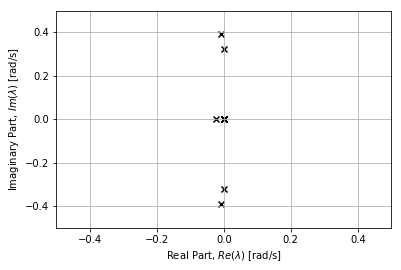

In [19]:
fig = plt.figure()
plt.scatter(eigenvalues_trim[:, 0], eigenvalues_trim[:, 1],
           marker='x',
           color='k')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.xlabel('Real Part, $Re(\lambda)$ [rad/s]')
plt.ylabel('Imaginary Part, $Im(\lambda)$ [rad/s]');

#### Structural Modes

Looking further out on the plot, the structural modes appear. There is a curve given the Newmark-$\beta$ integration scheme and on top of it several modes are damped by the presence of the aerodynamics.

Try changing `newmark_damp` in the `LinearAssembler` settings to see how this plot changes!

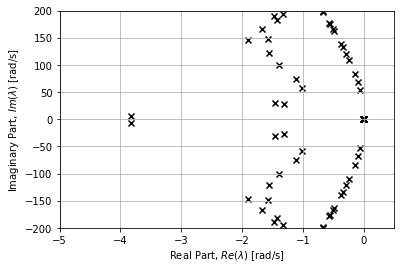

In [20]:
fig = plt.figure()
plt.scatter(eigenvalues_trim[:, 0], eigenvalues_trim[:, 1],
           marker='x',
           color='k')
plt.xlim(-5, 0.5)
plt.ylim(-200, 200)
plt.grid()
plt.xlabel('Real Part, $Re(\lambda)$ [rad/s]')
plt.ylabel('Imaginary Part, $Im(\lambda)$ [rad/s]');

### Stability Derivatives

Stability derivatives are calculated using the steady-state frequency response of the UVLM system.
The output is saved in `./output/<case_name>/stability/`. Note that stability derivatives are expressed in the SHARPy Frame of Reference, which is South East Up (not the conventional in flight dynamics literature).

This body attached frame of reference has:

* $x$ positive downstream

* $y$ positive towards the right wing

* $z$ positive up